In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.extensions import RXGate, RZGate
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit import  execute, BasicAer
import qiskit.quantum_info as qi
import scipy.optimize 
import random
import matplotlib.pyplot as plt
import pickle
import os 
from sklearn.model_selection import train_test_split
import time
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.circuit.library import RealAmplitudes
from sklearn.utils import shuffle

from qiskit.primitives import Sampler
from qiskit.circuit.library import ZZFeatureMap,ZFeatureMap
from qiskit_algorithms.optimizers import COBYLA,L_BFGS_B,ADAM
from IPython.display import clear_output
from qiskit import  execute, BasicAer

from qiskit.circuit import ParameterVector

from qiskit.primitives import Sampler
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit.circuit.library import ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR


from sklearn import metrics
from sklearn.metrics import RocCurveDisplay


In [2]:
#Iter="9"
Iter="extra_layer_9"

nLayer_realAmplitude = 2
MaxIter = 200
savePath = "rotational_dataset"
if "extra_layer" in Iter:
    nLayer_realAmplitude=4
    MaxIter=400
    savePath+="_extraLayer"


#name='_smear0.1_MaxTran5.0_shuffle1_scaling1'
name='_smear0.5_MaxTran5.0_shuffle1_scaling1'
resultsName="results"+name


folderDir="/Users/lizhelun/Desktop/QC/VQC-Permutable-Lorentz-symmetry/"
dataDir="/Users/lizhelun/Desktop/QC/VQC-Permutable-Lorentz-symmetry/Images"


#nShots=2**13

maxEvents=2000
training_results={}



with open(dataDir+"/label"+name+".pk", "rb") as fp:   #Pickling
    label=pickle.load(fp)
    
with open(dataDir+"/images"+name+".pk", "rb") as fp:   #Pickling
    images=pickle.load(fp)
    
X=images.reshape(images.shape[0],images.shape[1]*images.shape[2])
y=label


y[y==0]=-1



X,y=shuffle(X,y,random_state=1000)
train_ratio=0.6
X_train, X_valTest, y_train, y_valTest = train_test_split(X.copy(), y.copy(), train_size=train_ratio, random_state=100)
X_val, X_test, y_val, y_test = train_test_split(X_valTest, y_valTest, test_size=0.5, random_state=200)
#Normalizing everythings:
X_train=np.pi*2*X_train/X_train.max()
X_val=np.pi*2*X_val/X_val.max()
X_test=np.pi*2*X_test/X_test.max()

sampler = Sampler()
print("number of training: ",y_train.shape[0])
print("number of validation: ",y_val.shape[0])
print("number of test: ",y_test.shape[0])
print("Real amplitude layer",nLayer_realAmplitude)
print("SavePath = ",savePath)

number of training:  1200
number of validation:  400
number of test:  400
Real amplitude layer 4
SavePath =  rotational_dataset_extraLayer


In [3]:
def dataAugmentation(data):
    #centering
    meanValues=data.mean(axis=1)
    print(data.shape)
    print(meanValues.shape)
    data=data-meanValues[:,None,:]
    
    #scaling
    norm=np.linalg.norm(data,axis=2)
    scale=norm.max(axis=1)
    data=data/scale[:,None,None]
    
    return data

def Dot(data):
    output=[]
    
    for i in range(data.shape[0]):
        event=[]
        #first record dot product with itself:
        for j in range(data.shape[1]):
            event.append((data[i][j]*data[i][j]).sum())
            
        for j in range(data.shape[1]):
            for k in np.arange(j+1,data.shape[1]):
                event.append((data[i][j]*data[i][k]).sum())
        output.append(np.array(event))
    
    output=np.array(output)
    return output
    

In [4]:
X_centerScale=dataAugmentation(images).reshape(images.shape[0],images.shape[1]*images.shape[2])
y_centerScale=label
random_state=int(1000*np.random.rand())
print(random_state)

X_centerScale,y_centerScale=shuffle(X_centerScale,y_centerScale,random_state=random_state)
train_ratio=0.6
X_train_centerScale, X_valTest_centerScale, y_train_centerScale, y_valTest_centerScale = train_test_split(X_centerScale.copy(), y_centerScale.copy(), train_size=train_ratio, random_state=100)
X_val_centerScale, X_test_centerScale, y_val_centerScale, y_test_centerScale = train_test_split(X_valTest_centerScale, y_valTest_centerScale, test_size=0.5, random_state=200)
#Normalizing everythings:
X_train_centerScale=X_train_centerScale/X_train_centerScale.max()
X_val_centerScale=X_val_centerScale/X_val_centerScale.max()
X_test_centerScale=X_test_centerScale/X_test_centerScale.max()



X_augDot=Dot(dataAugmentation(images))
y_augDot=label



X_augDot,y_augDot=shuffle(X_augDot,y_augDot,random_state=random_state)
train_ratio=0.6
X_train_augDot, X_valTest_augDot, y_train_augDot, y_valTest_augDot = train_test_split(X_augDot.copy(), y_augDot.copy(), train_size=train_ratio, random_state=random_state)
X_val_augDot, X_test_augDot, y_val_augDot, y_test_augDot = train_test_split(X_valTest_augDot, y_valTest_augDot, test_size=0.5, random_state=random_state)
#Normalizing everythings:
X_train_augDot=X_train_augDot/X_train_augDot.max()
X_val_augDot=X_val_augDot/X_val_augDot.max()
X_test_augDot=X_test_augDot/X_test_augDot.max()

num_qubits=X_augDot.shape[1]



(2000, 4, 2)
(2000, 2)
845
(2000, 4, 2)
(2000, 2)


In [5]:
def cost_func(params,estimator,X,y):
    """
    input: 
        params: list of parameters
        num_qubit: number of qubits
        num_layers: number of layers
        j_coupling: coeffecient in ZZ terms
        h_coupling: coefficient in X terms
        ansatz_type: type of ansatz (HEA or HVA)
        
    output: value of cost function (VEV of Hamiltonian)
    
    global variables:
        cost_val_list: list of cost function values
    """
    global cost_val_list
    global AUC_list
    
    
    pred = estimator.forward(X,params).flatten()
    fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=1)
    AUC= metrics.auc(fpr, tpr)
#     cost_val=(((pred-y)/2)**2).sum()/y.shape[0]
    #cost_val=((pred-y)**2).sum()
    cost_val=((pred-y)**2).sum()/(4*y.shape[0])
    
    cost_val_list.append(cost_val)
    AUC_list.append(AUC)
    clear_output(wait=True)
    
    plt.plot(np.arange(0,len(cost_val_list)), cost_val_list)
    plt.xlabel('iteration')
    plt.ylabel('cost function')
    plt.legend()
    plt.show()
    return cost_val

def getBestTheshold(est,params,X_test,y_test):
    y_predict=est.forward(X_test,params).flatten()
    #plt.hist(y_predict)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict, pos_label=1)

    bestValidation=0
    threshold_best=0
    for t in thresholds:
        y=y_predict.copy().flatten()
        y[y>t]=1
        y[y<t]=-1
        diff=y-y_test
        val=diff[diff==0].shape[0]/y.shape[0]
        if val>bestValidation:
            bestValidation=val
            threshold_best=t
            print(val,threshold_best)
    return threshold_best

def computeAccuracy(est,params,X_test,y_test,threshold):
    y=est.forward(X_test,params).flatten()

    y[y>=threshold]=1
    y[y<threshold]=-1
    diff=y-y_test
    acc=diff[diff==0].shape[0]/y.shape[0]
    return acc
    

Baseline

In [6]:
# nLayer_realAmplitude=4
num_qubits=X_train_centerScale.shape[1]
n_inputParams=num_qubits
n_params=nLayer_realAmplitude*num_qubits
N_particles=4
#print(num_qubits)

qr = QuantumRegister(num_qubits)
qc = QuantumCircuit(qr)
feature_map = ZFeatureMap(feature_dimension=num_qubits,reps=1,parameter_prefix="inputs")
ansatz=RealAmplitudes(num_qubits, reps=nLayer_realAmplitude)
qc.compose(feature_map, inplace=True) 
qc.compose(ansatz,inplace=True)    

zeroState = '0'
for i in range(num_qubits-1):
    zeroState+='0'
def countZero(x):
    return f"{bin(x)}".count("0")%(num_qubits+1)

observable1 = SparsePauliOp.from_list([("Z" * num_qubits, 1)])

estimator_qnn_baseline2 = EstimatorQNN(
    circuit=qc, observables=observable1, input_params=feature_map.parameters, weight_params=ansatz.parameters
)

method='COBYLA'

initial_weights=np.pi*2*np.random.rand(estimator_qnn_baseline2.num_weights)
cost_val_list=[]
AUC_list=[]



In [7]:
qc.depth()

2

/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


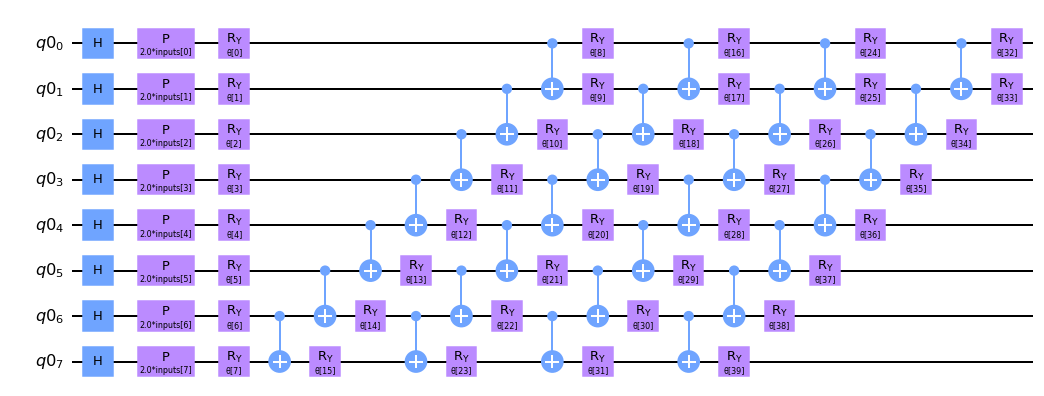

In [8]:
qc.decompose().draw('mpl')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


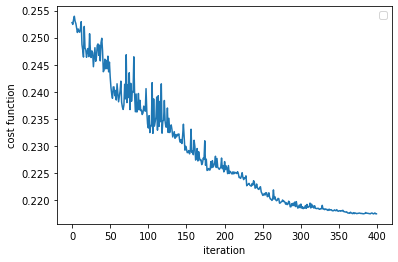

In [9]:
res_baseline2 = scipy.optimize.minimize(cost_func, initial_weights,method=method,options={'maxiter':MaxIter}
                              ,args=(estimator_qnn_baseline2,X_train_centerScale[0:maxEvents], y_train_centerScale[0:maxEvents])) #minimize cost function via scipy
cost_val_list_baseline2=cost_val_list
AUC_list_baseline2=AUC_list
params_baseline2=res_baseline2.x

In [10]:
print(params_baseline2)

[ 1.63738573  5.38950905  0.13120333  4.511496    7.1600096   3.51583931
  2.79757288  5.84543904 -0.38089569  3.15314024  0.34013128  6.28231828
  7.26487072  5.37329339  6.26263216  6.3639868   3.3979163   1.43182401
  6.65682069  0.61810871  2.05672889  3.21364764  4.86664162  1.03126046
  6.13928855  3.2512236   1.25387057  6.29873057  2.97425533  4.84928647
  0.55358626  2.24110598  3.19471748  6.0930291   3.86338641  0.18225929
  3.42275662  2.91272698  4.97313359  4.46239385]


In [11]:
y_test_pred_baseline2=estimator_qnn_baseline2.forward(X_test_centerScale[0:maxEvents],params_baseline2).flatten()
fpr_b2, tpr_b2, thresholds_b2 = metrics.roc_curve(y_test_centerScale[0:maxEvents],y_test_pred_baseline2, pos_label=1)
print(metrics.auc(fpr_b2,tpr_b2))

0.739040404040404


In [12]:
np.save(savePath+"/tpr_b2_{}".format(Iter),tpr_b2)
np.save(savePath+"/fpr_b2_{}".format(Iter),fpr_b2)
np.save(savePath+"/cost_val_list_baseline2_{}".format(Iter),np.array(cost_val_list_baseline2))

Rotation

In [13]:
N_particles=4
num_qubits=int((N_particles+1)*N_particles/2)

In [14]:
qr_rot = QuantumRegister(num_qubits)
qc_rot = QuantumCircuit(qr_rot)
feature_map_rot = ZFeatureMap(feature_dimension=num_qubits,reps=1,parameter_prefix="inputs")
ansatz_rot=RealAmplitudes(num_qubits, reps=nLayer_realAmplitude)

qc_rot.compose(feature_map_rot, inplace=True) 
qc_rot.compose(ansatz_rot,inplace=True)    


In [15]:
qc_rot.depth()

2

In [16]:
observable1 = SparsePauliOp.from_list([("Z" * num_qubits, 1)])
estimator_qnn_rot2 = EstimatorQNN(
    circuit=qc_rot, observables=observable1, input_params=feature_map_rot.parameters, weight_params=ansatz_rot.parameters
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


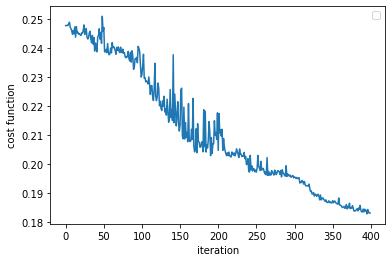

In [17]:
zeroState = '0'
for i in range(num_qubits-1):
    zeroState+='0'
def countZero(x):
    return f"{bin(x)}".count("0")%(num_qubits+1)


method='COBYLA'
#initial_weights=res_rot2.x
initial_weights=np.pi*2*np.random.rand(estimator_qnn_rot2.num_weights)
cost_val_list=[]
AUC_list=[]


res_rot2= scipy.optimize.minimize(cost_func, initial_weights,method=method,options={'maxiter':MaxIter}
                              ,args=(estimator_qnn_rot2,X_train_augDot[0:maxEvents], y_train_augDot[0:maxEvents])) #minimize cost function via scipy
cost_val_list_rot2=cost_val_list
AUC_list_rot2=AUC_list
params_rot2=res_rot2.x

In [18]:
y_test_pred_rot2=estimator_qnn_rot2.forward(X_test_augDot[0:maxEvents],params_rot2).flatten()
fpr_rot2, tpr_rot2, thresholds_rot2 = metrics.roc_curve(y_test_augDot[0:maxEvents],y_test_pred_rot2, pos_label=1)
print(metrics.auc(fpr_rot2,tpr_rot2))

0.8389276864158594


In [19]:
np.save(savePath+"/tpr_rot2_{}".format(Iter),tpr_rot2)
np.save(savePath+"/fpr_rot2_{}".format(Iter),fpr_rot2)
np.save(savePath+"/cost_val_list_rot2_{}".format(Iter),np.array(cost_val_list_rot2))


/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


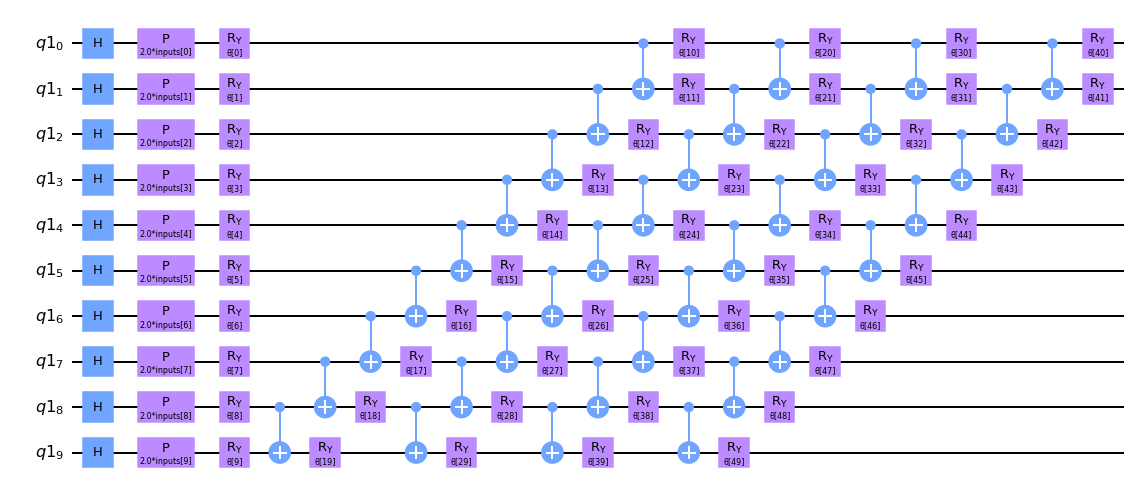

In [20]:
qc_rot.decompose().draw('mpl')

In [21]:
qc_rot.num_parameters

60

Rotation+Permutation

In [22]:
# num_layers=2
# n_inputParams=num_qubits
# n_params=num_layers*4
# N_particles=4
# num_qubits=int((N_particles+1)*N_particles/2)

In [23]:
# qr = QuantumRegister(num_qubits)
# qc = QuantumCircuit(qr)
# feature_map = ZFeatureMap(feature_dimension=num_qubits,reps=1,parameter_prefix="inputs")


# weights = ParameterVector("weight", n_params)
# print(f"weight parameters: {[str(item) for item in weights.params]}")

# inputParams_index=0
# params_index=0


# qc.compose(feature_map, inplace=True) 
   
# for layer in range(num_layers):
    
#         for i in range(N_particles):
#             qc.ry(weights[params_index],i)
            
#         params_index += 1 
        
#         for i in range(N_particles):
#             for k in np.arange(i,N_particles,1):
#                 if i!=k:
#                     qc.rzz(weights[params_index],i,k)
            
            
#         params_index += 1
#         for j in np.arange(N_particles,num_qubits,1):
#             qc.ry(weights[params_index],j)
#         params_index += 1
        
#         for i in np.arange(N_particles,num_qubits,1):
#             for k in np.arange(i,num_qubits,1):
#                 if i!=k:
#                     qc.rzz(weights[params_index],i,k)
                    
#         params_index += 1
            
        
#         qc.barrier()

In [24]:
# observable1 = SparsePauliOp.from_list([("Z" * num_qubits, 1)])
# estimator_qnn_rotPerm = EstimatorQNN(
#     circuit=qc, observables=observable1, input_params=feature_map.parameters, weight_params=weights
# )

In [25]:
# qc.decompose().draw('mpl')

In [26]:


# zeroState = '0'
# for i in range(num_qubits-1):
#     zeroState+='0'
# def countZero(x):
#     return f"{bin(x)}".count("0")%(num_qubits+1)


# method='COBYLA'
# initial_weights=np.pi*2*np.random.rand(estimator_qnn_rotPerm.num_weights)
# cost_val_list=[]
# AUC_list=[]


# res_rotPerm = scipy.optimize.minimize(cost_func, initial_weights,method=method,options={'maxiter':MaxIter}
#                               ,args=(estimator_qnn_rotPerm,X_train_augDot[0:maxEvents], y_train_augDot[0:maxEvents])) #minimize cost function via scipy
# cost_val_list_rotPerm=cost_val_list
# AUC_list_rotPerm=AUC_list
# params_rotPerm=res_rotPerm.x

In [27]:
# y_test_pred_rotPerm=estimator_qnn_rotPerm.forward(X_test_augDot[0:maxEvents],params_rotPerm).flatten()
# fpr_rotPerm, tpr_rotPerm, thresholds_rotPerm = metrics.roc_curve(y_test_augDot[0:maxEvents],y_test_pred_rotPerm, pos_label=1)

Plotting

In [28]:
# np.save("rotational_dataset/tpr_b2_{}".format(Iter),tpr_b2)
# np.save("rotational_dataset/tpr_rot2_{}".format(Iter),tpr_rot2)
# np.save("rotational_dataset/tpr_rotPerm_{}".format(Iter),tpr_rotPerm)

# np.save("rotational_dataset/fpr_b2_{}".format(Iter),fpr_b2)
# np.save("rotational_dataset/fpr_rot2_{}".format(Iter),fpr_rot2)
# np.save("rotational_dataset/fpr_rotPerm_{}".format(Iter),fpr_rotPerm)

# np.save("rotational_dataset/cost_val_list_baseline2_{}".format(Iter),np.array(cost_val_list_baseline2))
# np.save("rotational_dataset/cost_val_list_rot2_{}".format(Iter),np.array(cost_val_list_rot2))
# np.save("rotational_dataset/cost_val_list_rotPerm_{}".format(Iter),np.array(cost_val_list_rotPerm))
